### Importing Prerequisites

In [ ]:
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf

### Mounting drive to access dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Unzip images to session storage

In [ ]:
!unzip 'drive/MyDrive/SCAII_Drive_Arjit_Agarwal_PS3/dataset.zip'

### Defining important variables

In [ ]:
BATCH_SIZE = 128
BUFFER_SIZE = 100000
train_split = 0.8
val_split = 0.1
test_split = 0.1
OUTPUT_CHANNELS = 3
EPOCHS = 25
IMG_SIZE = 224
base_learning_rate = 0.01
OUTPUT_SIZE = 12
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)


### Creating an array to store the path of classes

In [ ]:
data_dir = [pathlib.Path('dataset/Damaged_Infrastructure/Earthquake'),
            pathlib.Path('dataset/Damaged_Infrastructure/Infrastructure'),
            pathlib.Path('dataset/Fire_Disaster/Urban_Fire'),
            pathlib.Path('dataset/Fire_Disaster/Wild_Fire'),
            pathlib.Path('dataset/Human_Damage'),
            pathlib.Path('dataset/Land_Disaster/Drought'),
            pathlib.Path('dataset/Land_Disaster/Land_Slide'),
            pathlib.Path('dataset/Non_Damage/human'),
            pathlib.Path('dataset/Non_Damage/Non_Damage_Buildings_Street'),
            pathlib.Path('dataset/Non_Damage/Non_Damage_Wildlife_Forest'),
            pathlib.Path('dataset/Non_Damage/sea'),
            pathlib.Path('dataset/Water_Disaster'),
            ]

### If you want to manually download the dataset from kaggle and use the implementation code there, make sure to run the helper code first to delete any corrupt files, otherwise there is no need to run this.

In [ ]:
import os
import PIL
from PIL import Image
for source_dir in data_dir:
    source_list = os.listdir(source_dir)
    for file in source_list:
        fpath = os.path.join(source_dir, file)
        try:
            img = tf.io.read_file(fpath)
            image = tf.image.decode_png(img, channels=3)
        except:
            os.remove(fpath)
            print('file ', fpath, ' is an invalid image file')
print('***** process completed *****')

### Read all the images and store them according to classes in a list

In [ ]:
data_fnames = []

for file_path in data_dir:
  filenames = list(file_path.glob('*.png'))
  print("image count: ", len(filenames))
  fnames = []
  for fname in filenames:
    fnames.append(str(fname))
  data_fnames.append(fnames)


image count:  36
image count:  1417
image count:  418
image count:  510
image count:  240
image count:  201
image count:  453
image count:  120
image count:  4572
image count:  2271
image count:  2274
image count:  1035


### Defining all the possible labels for the classification

In [ ]:
labels = [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]

data_labels = []


### Creating a list containing all the corresponding labels of the images in dataset

In [ ]:
for index, label in enumerate(labels):
    temp = []
    for i in range(0, len(data_fnames[index])):
        temp.append(label)
    data_labels.append(temp)


### A function which takes in the group of images and their corresponding lables to convert them into a tensorflow dataset

In [ ]:
def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))  # .cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds


### Creating a classwise list of training, validation and test dataset

In [ ]:
train_ds_list = []
val_ds_list = []
test_ds_list = []
for fnames , labels in zip(data_fnames,data_labels):
    train_ds = make_ds(fnames, labels)
    test_ds_list.append(train_ds.take(int(len(labels) * test_split)))
    val_ds_list.append(train_ds.skip(int(len(labels) * test_split)).take(int(len(labels) * val_split)))
    train_ds_list.append(train_ds.skip(int(len(labels) * test_split)).skip(int(len(labels) * val_split)).take(int(len(labels)*train_split)))



### Class weights contain the probablities of a class image to be sampled from the dataset created from the culmination of all the class datasets. Have each probablity almost the same this can be thought of as un upsampling technique.

In [ ]:
class_weights = [0.084, 0.083, 0.083, 0.083,
                 0.084, 0.084, 0.083, 0.084, 0.083, 0.083, 0.083, 0.083]


### Creating a final combined dataset from all the mini datasets of classes

In [ ]:

upsampled_train_ds = tf.data.experimental.sample_from_datasets(
    train_ds_list, weights=class_weights)

upsampled_val_ds = tf.data.experimental.sample_from_datasets(
    val_ds_list, weights=class_weights)

upsampled_test_ds = tf.data.experimental.sample_from_datasets(
    test_ds_list, weights=class_weights)


Instructions for updating:
Use `tf.data.Dataset.random(...)`.


### Function to decode and convert the image to an actual tensor containing [0-255] pixel values

In [ ]:
def process_images(file_path, label):
  img = tf.io.read_file(file_path)
  img = tf.io.decode_png(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE],
                        method='nearest', antialias=True)
  return img, label


### Below maps all the paths in the dataset to the above code cell

In [ ]:
upsampled_train_ds = upsampled_train_ds.map(
    process_images, num_parallel_calls=tf.data.AUTOTUNE)

upsampled_val_ds = upsampled_val_ds.map(
    process_images, num_parallel_calls=tf.data.AUTOTUNE)

upsampled_test_ds = upsampled_test_ds.map(
    process_images, num_parallel_calls=tf.data.AUTOTUNE)


### Dataset batching and prefetching done for a performance boost.

In [ ]:

upsampled_train_ds = upsampled_train_ds.batch(
    BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

upsampled_val_ds = upsampled_val_ds.batch(
    BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

upsampled_test_ds = upsampled_test_ds.batch(1).prefetch(tf.data.AUTOTUNE)


### Plot the pictures to see if everything is working as intended so far 

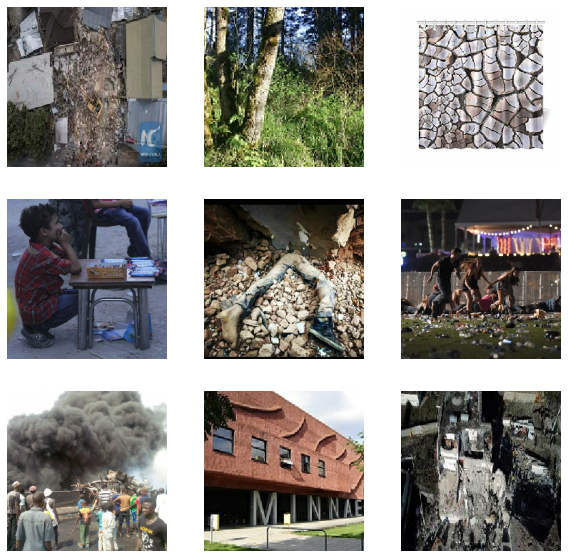

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in upsampled_train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #plt.title(class_names[labels[i]])
    plt.axis("off")


### Simple data augmentations

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
])


### Looking at the effects of applied augmentations

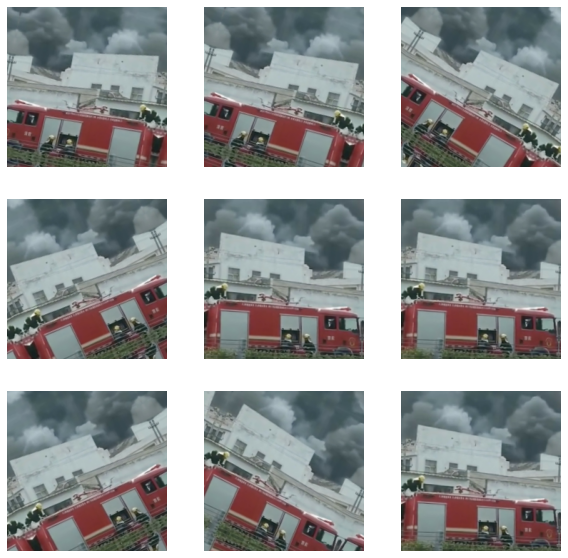

In [ ]:
for image, _ in upsampled_train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### For transfer learning, I used MobileNetV2 as a base model. I used this because it is comapratively smaller and faster than other models out there with very similar performance.

In [ ]:

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


9420800/9406464 [==============================] - 0s 0us/step


### I have also used the default preprocess method given for the mobilenet model which normalises images to a range of [-1,1]

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


### Running the model to find the shape of outputs generated

In [ ]:
image_batch, label_batch = next(iter(upsampled_train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(128, 7, 7, 1280)


### Before Fine tuning I'll need to freeze all the layers of the base model so that I can make use of the already trained weights.

In [ ]:
base_model.trainable = False


### A Global Average Pooling 2D layer to convert the (7,7,1280) feature vector into a (1,1280) vector

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(128, 1280)


### A prediction layer consisting of one dense layer with the output size same as the total number of classes.

In [ ]:
prediction_layer = tf.keras.Sequential([
    tf.keras.layers.Dense(OUTPUT_SIZE, activation='softmax', use_bias=False,
                          kernel_regularizer=tf.keras.regularizers.l2(0.01))
])
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(128, 12)


### Finally building a model consisting of all the preprocessing, augmentation and the training block

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


### Since I have a Balanced dataset, I am only using Accuracy as a sole metric to evlauate my model. This accuracy is the number of times the model matches predicted labels to the true labels

In [ ]:
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
]


### I am using Adam as my optimizer because it is a great all round optimizer for common tasks like image classification as in this case. For the loss I have used the standard categorical crossentropy loss function.

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss='categorical_crossentropy',
    metrics=METRICS)


### Adding an early stopping callback to stop training before the model starts to overfit on data

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    verbose=1,
    patience=30,
    mode='max',
    restore_best_weights=True)


### Finally calling the fit method to train the model

In [ ]:
resampled_history = model.fit(
    upsampled_train_ds,
    epochs=200,
    steps_per_epoch=1,
    callbacks=[early_stopping],
    validation_data=upsampled_val_ds,
    validation_steps=1
)


Epoch 1/200
1/1 [==============================] - 8s 8s/step - loss: 3.2184 - accuracy: 0.1250 - val_loss: 3.1470 - val_accuracy: 0.2031
Epoch 2/200
1/1 [==============================] - 1s 1s/step - loss: 3.7991 - accuracy: 0.1953 - val_loss: 2.7429 - val_accuracy: 0.3828
Epoch 3/200
1/1 [==============================] - 2s 2s/step - loss: 2.9537 - accuracy: 0.3594 - val_loss: 2.1881 - val_accuracy: 0.5703
Epoch 4/200
1/1 [==============================] - 1s 1s/step - loss: 2.7428 - accuracy: 0.5000 - val_loss: 1.7497 - val_accuracy: 0.6016
Epoch 5/200
1/1 [==============================] - 1s 1s/step - loss: 2.4170 - accuracy: 0.5312 - val_loss: 2.1495 - val_accuracy: 0.5312
Epoch 6/200
1/1 [==============================] - 1s 1s/step - loss: 1.9324 - accuracy: 0.5938 - val_loss: 1.4607 - val_accuracy: 0.6484
Epoch 7/200
1/1 [==============================] - 1s 1s/step - loss: 1.4895 - accuracy: 0.6641 - val_loss: 2.0271 - val_accuracy: 0.5234
Epoch 8/200
1/1 [=================

### A simple graph to plot accuracy and loss

In [ ]:
def plot_graph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()), 1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.ylim([0, 5.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


### From looking at the graph, it is clear that the model starts to overfit after 25 epochs. Therefore the weights of roughly epoch 20 are now saved.

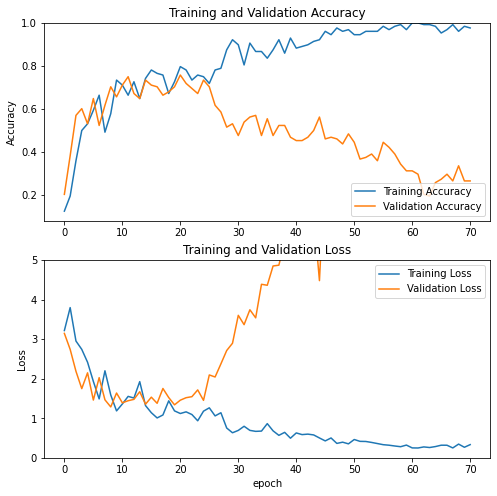

In [ ]:
plot_graph(resampled_history)

### An evaluation on the test dataset reveals an accuracy of about 85%

In [ ]:
model.evaluate(upsampled_test_ds)


1351/1351 [==============================] - 19s 14ms/step - loss: 0.8214 - accuracy: 0.8520


[0.8214407563209534, 0.8519614934921265]

# Fine Tuning

### To begin fine tuning, we first make all the layers of the model to be trainable

In [ ]:
base_model.trainable = True


### I have kept so that the layers from 100 onwards are trainable. The total numbers in this model are 154.

In [ ]:
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False


### Finally compiling the model with the learning rate set to a lot smaller than the initial learning rate so that the layers are fine tuned and not completely changed

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/1000),
              metrics=['accuracy'])


### Training the model from the last epoch

In [ ]:
history_fine = model.fit(upsampled_train_ds,
                         epochs=2000,
                         steps_per_epoch=1,
                         initial_epoch=resampled_history.epoch[-1],
                         callbacks=[early_stopping],
                         validation_data=upsampled_val_ds,
                         validation_steps=1)


Epoch 71/2000
1/1 [==============================] - 8s 8s/step - loss: 2.3662 - accuracy: 0.6406 - val_loss: 1.3922 - val_accuracy: 0.7188
Epoch 72/2000
1/1 [==============================] - 2s 2s/step - loss: 2.0452 - accuracy: 0.6641 - val_loss: 1.1513 - val_accuracy: 0.7656
Epoch 73/2000
1/1 [==============================] - 2s 2s/step - loss: 1.7544 - accuracy: 0.6484 - val_loss: 1.1916 - val_accuracy: 0.7422
Epoch 74/2000
1/1 [==============================] - 1s 1s/step - loss: 0.9351 - accuracy: 0.7891 - val_loss: 1.1574 - val_accuracy: 0.7891
Epoch 75/2000
1/1 [==============================] - 2s 2s/step - loss: 1.2097 - accuracy: 0.7500 - val_loss: 1.1907 - val_accuracy: 0.7500
Epoch 76/2000
1/1 [==============================] - 2s 2s/step - loss: 1.0461 - accuracy: 0.7969 - val_loss: 1.0152 - val_accuracy: 0.7891
Epoch 77/2000
1/1 [==============================] - 1s 1s/step - loss: 0.9424 - accuracy: 0.8203 - val_loss: 1.0250 - val_accuracy: 0.7734
Epoch 78/2000
1/1 [=

### By looking at the graph, it is clear that there is some increase in the accuracy of the model

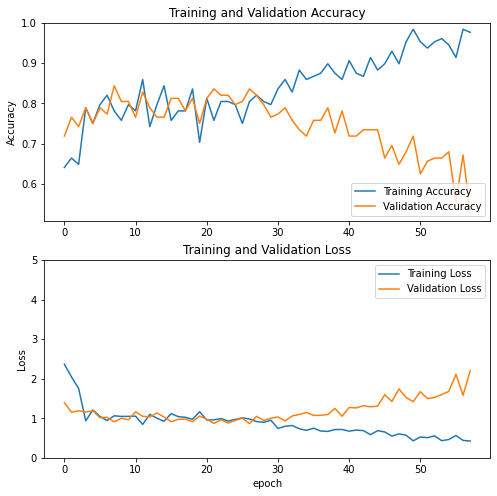

In [ ]:
plot_graph(history_fine)

### Finally after evaluation again on the test set, it is found that the accuracy is further increased by about 3% totalling to about 88%

In [ ]:
model.evaluate(upsampled_test_ds)


1351/1351 [==============================] - 19s 14ms/step - loss: 0.7191 - accuracy: 0.8808


[0.7190781831741333, 0.8808290362358093]

In [ ]:
#model.save('model_acc_87_8.h5')